Data exploration

In [3]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor, DummyClassifier
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.linear_model import LinearRegression

## Data Preparation

### Data Ingestion

In [4]:
df = pd.read_csv("youth_data.csv")

substance_dict = {
    "iralcfy": "alcohol frequency past year (1-365)",
    "irmjfy": "marijuana frequency past year (1-365)",
    "ircigfm": "cigarette frequency past month (1-30)",
    "IRSMKLSS30N": "smokeless tobacco frequency past month (1-30)",
    "iralcfm": "alcohol frequency past month (1-30)",
    "irmjfm": "marijuana frequency past month (1-30)",
    "ircigage": "cigarette age of first use (1-55), 991=never used",
    "irsmklsstry": "smokeless tobacco age of first use (1-70), 991=never used",
    "iralcage": "alcohol age of first use (1-66), 991=never used",
    "irmjage": "marijuana age of first use (1-83), 991=never used",
    "mrjflag": "marijuana ever used (0=never, 1=ever)",
    "alcflag": "alcohol ever used (0=never, 1=ever)",
    "tobflag": "any tobacco ever used (0=never, 1=ever)",
    "alcydays": "number of days of alcohol in past year (1-5 categories, 6=none)",
    "mrjydays": "number of days of marijuana in past year (1-5 categories, 6=none)",
    "alcmdays": "number of days of alcohol in past month (1-4 categories, 5=none)",
    "mrjmdays": "number of days of marijuana in past month (1-4 categories, 5=none)",
    "cigmdays": "number of days of cigarettes in past month (1-5 categories, 6=none)",
    "smklsmdays": "number of days of smokeless tobacco in past month (1-4 categories, 5=none)",
}

# for recorded columns (RC), source variable is commented
demographic_dict = {
    # misc
    "irsex": "binary sex (1=male, 2=female)",
    "NEWRACE2": "RC-RACE/HISPANICITY RECODE", # Unspecified,
    "HEALTH2": "RC-OVERALL HEALTH RECODE", # HEALTH
    "talkprob": "RC-WHO YTH TALKS WITH ABOUT SERIOUS PROBLEMS", # YETLKBGF, YETLKNON, YETLKOTA, YETLKPAR, YETLKSOP

    # perception about other youth columns
    "stndscig": "RC-STUDENTS IN YTH GRADE SMOKE CIGARETTES", # YESTSCIG
    "stndsmj": "RC-STUDENTS IN YTH GRADE USE MARIJUANA", # YESTSMJ
    "stndalc": "RC-STUDENTS IN YTH GRADE DRINK ALCOHOLIC BEVERAGES", # YESTSALC
    "stnddnk": "RC-STUDENTS IN YTH GRADE GET DRUNK ONCE/WEEK", # YESTSDNK
 
    # school columns
    "eduschlgo": "now going to school (1=yes, 2=no)",
    "EDUSCHGRD2": "what grade in now/will be in (11 categories, 98,99= blank/skip)",
    "eduskpcom": "how many days skipped school in past month (0-30, 94/97/98/99=blank/skip)",
    "schfelt": "RC-HOW YTH FELT: ABOUT GOING TO SCHOOL IN PST YR", # YESCHFLT
    "tchgjob": "RC-TEACHER LET YTH KNOW DOING GOOD JOB IN PST YR", # YETCGJOB
    "avggrade": "RC-GRADE AVERAGE FOR LAST GRADING PERIOD COMPLETED", # YELSTGRD

    # parental involvement columns
    "imother": "for youth, mother in household (1=yes, 2=no, 3=don't know, 4=over 18)",
    "ifather": "for youth, father in household (1=yes, 2=no, 3=don't know, 4=over 18)",
    "parchkhw": "RC-PARENTS CHECK IF HOMEWORK DONE IN PST YR", # YEPCHKHW
    "parhlphw": "RC-PARENTS HELP WITH HOMEWORK IN PST YR", # YEPHLPHW
    "PRCHORE2": "RC-PARENTS MAKE YTH DO CHORES AROUND HOUSE IN PST YR", # YEPCHORE
    "PRLMTTV2": "RC-PARENTS LIMIT AMOUNT OF TV IN PST YR", # YEPLMTTV
    "parlmtsn": "RC-PARENTS LIMIT TIME OUT ON SCHOOL NIGHT IN PST YR", # YEPLMTSN
    "PRGDJOB2": "RC-PARENTS TELL YTH HAD DONE GOOD JOB IN PST YR", # YEPGDJOB
    "PRPROUD2": " RC-PARENTS TELL YTH PROUD OF THINGS DONE IN PST YR", # YEPPROUD
    "argupar": "RC-TIMES ARGUED/HAD A FIGHT WITH ONE PARENT IN PST YR", # YEYARGUP
    "PRPKCIG2": "RC-YTH THINK: PARENTS FEEL ABT YTH SMOKE PACK CIG/DAY", # YEPPKCIG
    "PRMJEVR2": " RC-YTH THINK: PARENTS FEEL ABT YTH TRY MARIJUANA", # YEPMJEVR
    "prmjmo": "RC-YTH THINK: PARENTS FEEL ABT YTH USE MARIJUANA MNTHLY", # YEPMJMO
    "PRALDLY2": "RC-YTH THINK: PARNTS FEEL ABT YTH DRK 1-2 ALC BEV/DAY", # YEPALDLY
    "PRTALK3": "RC-TALKED WITH PARENT ABOUT DANGER TOB/ALC/DRG", # YEPRTDNG

    # community program columns   
    "PRBSOLV2": "RC-PARTICIPATED IN PRBSLV/COMMSKILL/SELFESTEEM GROUP", # YEPRBSLV
    "PREVIOL2": "RC-PARTICIPATED IN VIOLENCE PREVENTION PROGRAM", # YEVIOPRV
    "PRVDRGO2": "RC-PARTICIPATED IN SUBSTANCE PREV PROGRAM OUTSIDE SCHOOL", # YEDGPRGP
    "GRPCNSL2": "RC-PARTICIPATED IN PROGRAM TO HELP SUBSTANCE USE", # YESLFHLP
    "PREGPGM2": "RC-PARTICIPATED IN PREG/STD PREVENTION PROGRAM", # YEPRGSTD
    "YTHACT2": "RC-YTH PARTICIPATED IN YOUTH ACTIVITIES", # YECOMACT, YEFAIACT, YEOTHACT, YESCHACT
    "DRPRVME3": "RC-YTH SEEN ALC OR DRUG PREVENTION MESSAGE OUTSIDE SCHOOL", # YEPVNTYR
    "ANYEDUC3": "RC-YTH HAD ANY DRUG OR ALCOHOL EDUCATION IN SCHOOL", # YEDECLAS, YEDERGLR, YEDESPCL
    
    # religious beliefs columns
    "rlgattd": "RC-NUMBER TIMES ATTEND RELIGIOUS SERVICES IN PST YR", # YERLGSVC
    "rlgimpt": "RC-RELIGIOUS BELIEFS VERY IMPORTANT IN LIFE", # YERLGIMP
    "rlgdcsn": "RC-RELIGIOUS BELIEFS INFLUENCE LIFE DECISIONS", # YERLDCSN
    "rlgfrnd": "RC-IMPORTANT FOR FRIENDS TO SHARE RELIGIOUS BELIEFS", # YERLFRND

    # financial situation columns
    "income": "total family income (4 categories)",
    "govtprog": "got gov assistance (1=yes, 2=no)",
    "POVERTY3": "poverty level (4 categories)",

    # peer influence columns
    "YFLPKCG2": "RC-HOW YTH FEELS: PEERS SMOKE PACK/DAY CIG", # YEGPKCIG
    "YFLTMRJ2": "RC-HOW YTH FEELS: PEERS TRY MARIJUANA", # YEGMJEVR
    "yflmjmo": "RC-HOW YTH FEELS: PEERS USING MARIJUANA MONTHLY", # YEGMJMO
    "YFLADLY2": "RC-HOW YTH FEELS: PEERS DRNK 1-2 ALC BEV/DAY", # YEGALDLY
    "FRDPCIG2": "RC-YTH THINK: CLSE FRND FEEL ABT YTH SMK 1+ PAC DAILY", # YEFPKCIG
    "FRDMEVR2": "RC-YTH THINK: CLOSE FRNDS FEEL ABT YTH TRY MARIJUANA", # YEFMJEVR
    "frdmjmon": "RC-YTH THINK: CLSE FRNDS FEEL ABT YTH USE MARIJUANA MON", # YEFMJMO
    "FRDADLY2": "RC-YTH THINK: CLSE FRND FEEL ABT YTH HAVE 1-2 ALC/DAY", # YEFALDLY

    # societal environment columns
    "PDEN10": "population density (1= >1M people, 2=<1M people, 3=can't be determined)",
    "COUTYP4": "metro size status (1=large metro, 2=small metro, 3=nonmetro)",

    # violence and crime columns
    "YOFIGHT2": "RC-YOUTH HAD SERIOUS FIGHT AT SCHOOL/WORK", # YOFIGHT2
    "YOGRPFT2": "RC-YOUTH FOUGHT WITH GROUP VS OTHER GROUP", # YEYFGTGP
    "YOHGUN2": "RC-YOUTH CARRIED A HANDGUN", # YEYHGUN
    "YOSELL2": "RC-YOUTH SOLD ILLEGAL DRUGS", # YEYSELL
    "YOSTOLE2": "RC-YOUTH STOLE/TRIED TO STEAL ITEM >$50", # YEYSTOLE
    "YOATTAK2": "RC-YOUTH ATTACKED WITH INTENT TO SERIOUSLY HARM", # YEYATTAK
}

# if a row's columns has these values, either the row must be removed or the values must be imputed. These are our predictors. 
impute_cols = {
    "eduschlgo": [85, 94, 97, 98],
    "EDUSCHGRD2": [98, 99],
    "eduskpcom": [94, 97, 98, 99],
    "imother": [3],
    "ifather": [3],
    "PDEN10": [3],
}

# various other filters
numerical_cols = ['eduskpcom']
ordinal_cols = ['income', 'POVERTY3', 'PDEN10', 'COUTYP4', 'HEALTH2', 'EDUSCHGRD2'] # used just to filter the nominal columns, they're already encoded as ordinal
nominal_cols = list(set(demographic_dict.keys()) - set(ordinal_cols) - set(numerical_cols)) # most of them are actually already binary
nominal_cols_to_encode = ['NEWRACE2'] # these are the only ones that aren't binary

# further special handling for values that can be combined
df.loc[df['eduschlgo'] == 11, 'eduschlgo'] = 1

### Data Imputation

In [3]:
# impute all missing or 'bad' values as specified in the filter for our predictors, using all other predictors
# set bad values to np.nan so that they are imputed
for col, values in impute_cols.items():
    df[col] = df[col].replace(values, np.nan)

# use only other predictors to impute the missing values
demographic_data = df[list(demographic_dict.keys())]
imputer = IterativeImputer(estimator=RandomForestClassifier(random_state=333), max_iter=10, random_state=333)

# round the imputed values to the nearest integer since they are categorical
df[list(demographic_dict.keys())] = np.round(imputer.fit_transform(df[list(demographic_dict.keys())]))

# after adding NaNs to a column of type int, it becomes float, so convert it back to int
for col in demographic_dict.keys():
    df[col] = df[col].astype('int')

# convert categorical column types, so get_dummies will work properly
for col in ordinal_cols + nominal_cols:
    df[col] = df[col].astype('category')

/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Data Encoding

In [4]:
# encode categorical columns. 
# in our case, all of our ordinal columns are already encoded. Though most of our nominal columns are already binary, we will encode them anyway
df_dummies = pd.get_dummies(df[nominal_cols_to_encode], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)
df = df.drop(columns=nominal_cols_to_encode)

## Regression: 'iralcage'

'iralcage' is defined as alcohol age of first use. Since it is a numerical variable, we will use regression models starting with Random Forest Regression.

### Data Preparation

We will remove the predictor 'EDUSCHGRD2' (a youth's grade in school) as it is essentially a proxy for age. It is not insightful as it is self-evident that alcohol use is more likely as a youth grows older.

In [5]:
# Remove all rows where 'iralcage' == 991 (means never used, we can combine these findings with alcflag later)
df_iralcage = df.copy()
df_iralcage = df_iralcage[df_iralcage['iralcage'] != 991]
df_iralcage = df_iralcage.drop(columns=['EDUSCHGRD2'])
X = df_iralcage.drop(substance_dict.keys(), axis=1)
y = df_iralcage['iralcage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=333)

### Single-Parameter Tuning

Single-parameter tuning allows us to more easily visualize the effects of each parameter on MSE and choose values that results in a simpler model, but may not give us the "best" values. Furthermore, it is computationally less expensive as the search space is explored sequentially rather than exhaustively.

#### Baseline Model

Test MSE: 5.46


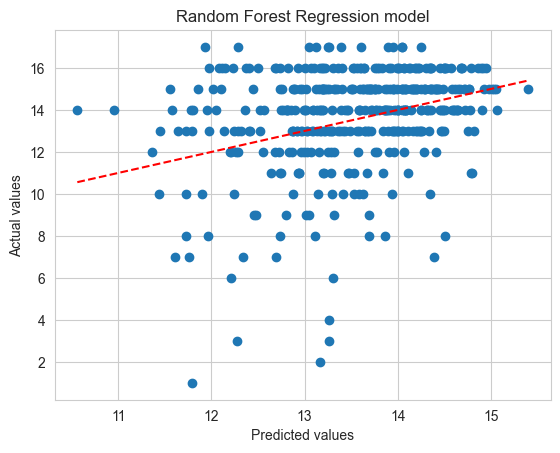

In [6]:
rf = RandomForestRegressor(max_features='sqrt', n_estimators=100, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# plot predicted vs actual values
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], 'r--')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random Forest Regression model');

# mse
print("Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

#### Tune 'n_estimators'

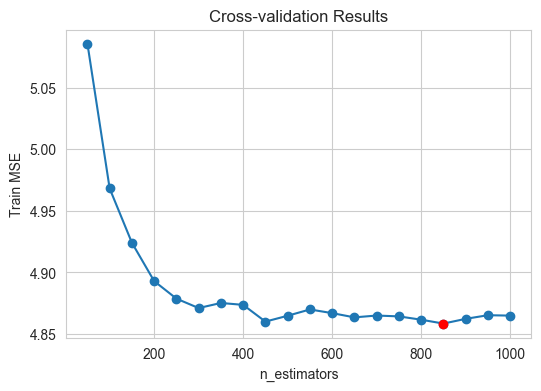

best_n_estimators: 850
best_score: 4.85854251903182


In [7]:
cv_params = {'n_estimators': np.arange(50, 1001, 50)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);
cv_results = cv.cv_results_
cv_results['mean_test_score'] = -cv_results['mean_test_score']
best_n_estimators = cv.best_params_['n_estimators']
best_score = -cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], 'o-')
plt.plot(best_n_estimators, best_score, 'ro-')
plt.xlabel('n_estimators')
plt.ylabel('Train MSE')
plt.title('Cross-validation Results')
plt.show()
print(f"best_n_estimators: {best_n_estimators}")
print(f"best_score: {best_score}")

The best 'n_estimators' is large at 850. We could use n_estimators=300 which seems to be the point where improvements slow down.

#### Tune 'max_features'

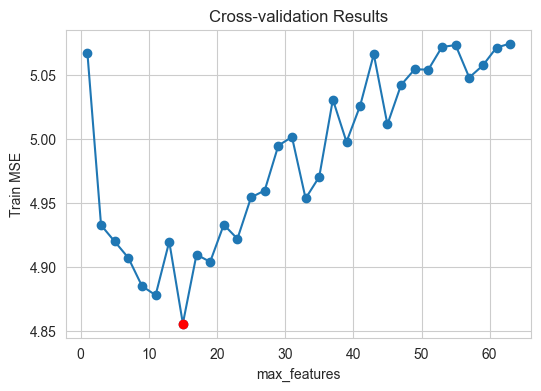

best_max_features: 15
best_score: 4.855851022748845


In [8]:
rf.set_params(n_estimators=300)
cv_params = {'max_features': np.arange(1, X_train.shape[1] + 1, 2)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train)
cv_results = cv.cv_results_
cv_results['mean_test_score'] = -cv_results['mean_test_score']
best_max_features = cv.best_params_['max_features']
best_score = -cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_max_features'], cv_results['mean_test_score'], 'o-')
plt.plot(best_max_features, best_score, 'ro-')
plt.xlabel('max_features')
plt.ylabel('Train MSE')
plt.title('Cross-validation Results')
plt.show()
print(f"best_max_features: {best_max_features}")
print(f"best_score: {best_score}")

The best 'max_features' is 15, but a value of 9 or 11 provides similar performance.

#### Evaluation

Test MSE: 5.40


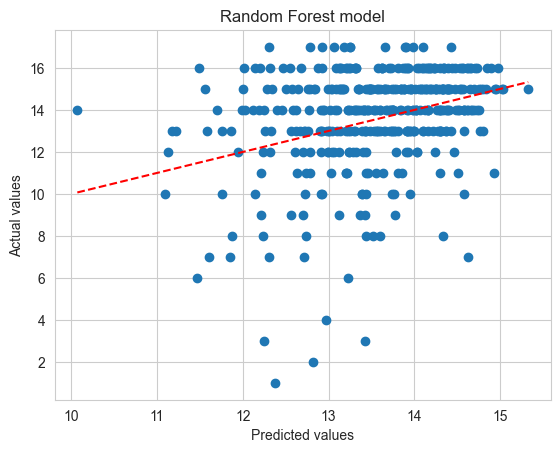

In [9]:
rf = RandomForestRegressor(n_estimators=300, max_features=9, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# plot predicted vs actual values
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], 'r--')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random Forest model');

# mse
print("Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

### Multi-Parameter Tuning

In contrast, multi-parameter tuning is much more computationally expensive as we test every single permutation, but it may give better results

#### Tune both 'n_estimators' and 'max_features'

In [10]:
cv_params = {'n_estimators': np.arange(50, 501, 50), 'max_features': np.arange(1, X_train.shape[1] + 1, 3)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);

In [11]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']  # Convert to positive mse
cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
best_n_estimators = cv.best_params_['n_estimators']
best_max_features = cv.best_params_['max_features']
best_score = -cv.best_score_

/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/93146722.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/93146722.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/93146722.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')


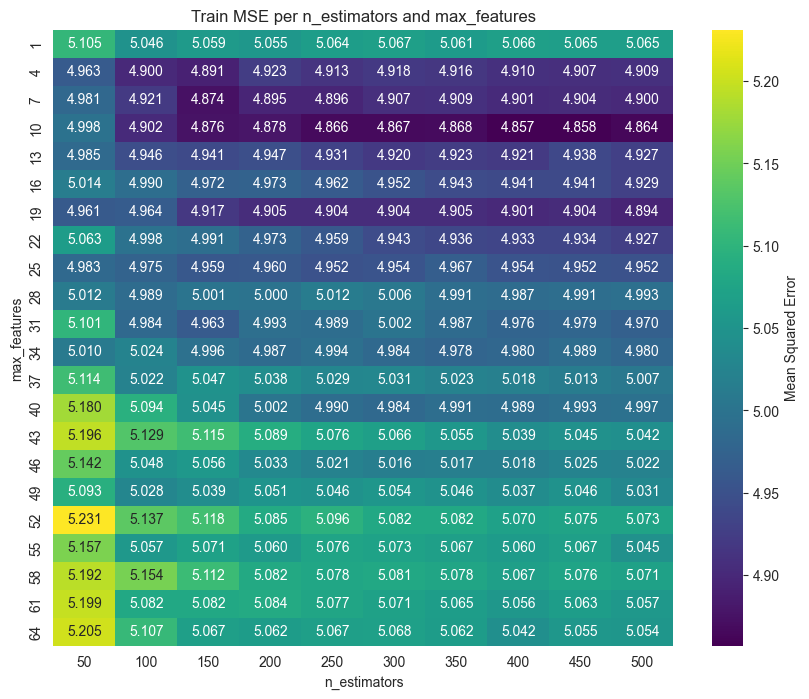

best_n_estimators: 400
best_max_features: 10
best_score: 4.857062718624659


In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(cv_table, annot=True, fmt=".3f", cmap='viridis', cbar_kws={'label': 'Mean Squared Error'})
plt.title('Train MSE per n_estimators and max_features')
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.show()

print(f"best_n_estimators: {best_n_estimators}")
print(f"best_max_features: {best_max_features}")
print(f"best_score: {best_score}")

#### Evaluation

Test MSE: 5.43


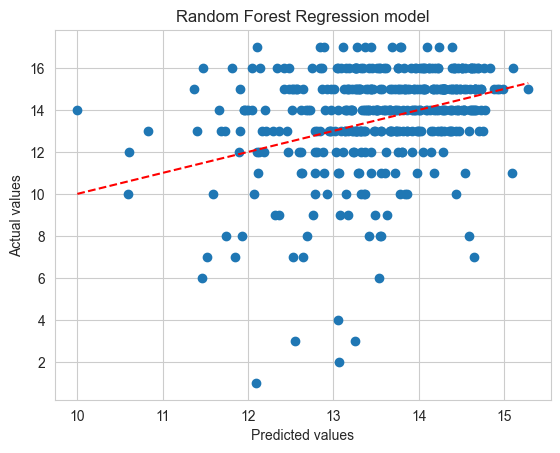

In [13]:
rf = RandomForestRegressor(max_features=best_max_features, n_estimators=best_n_estimators, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# plot predicted vs actual values
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], 'r--')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random Forest Regression model');

# mse
print("Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

The result is slightly worse than the model produced by single-parameter tuning, though with similar complexity (n_estimators=400 and max_features=10 vs n_estimators=300 and max_features=9)

### Model Comparisons

Here we will compare our Random Forest Regression against other models

In [14]:
# null model
null_model = DummyRegressor(strategy='mean')
null_model.fit(X_train, y_train)
y_pred = null_model.predict(X_test)
print("Null Model Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

Null Model Test MSE: 5.91


In [15]:
# OLS
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print("OLS Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

OLS Test MSE: 5.44


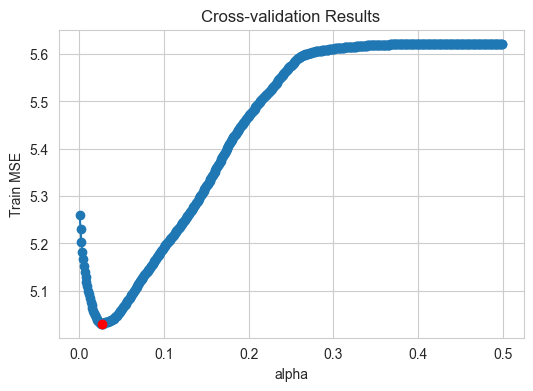

best_alpha: 0.027000000000000003
best_score: 5.0302207249554005
Test MSE: 5.36


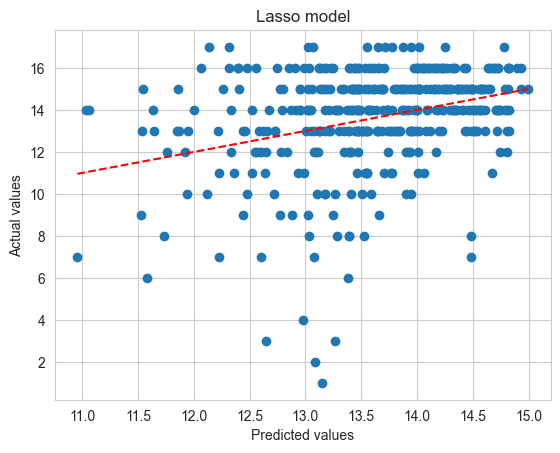

In [16]:
lasso = Lasso(random_state=333)
cv_params = {'alpha': np.arange(0.001, 0.5, 0.001)}
cv = GridSearchCV(lasso, cv_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);
cv_results = cv.cv_results_
cv_results['mean_test_score'] = -cv_results['mean_test_score']
best_alpha = cv.best_params_['alpha']
best_score = -cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'o-')
plt.plot(best_alpha, best_score, 'ro-')
plt.xlabel('alpha')
plt.ylabel('Train MSE')
plt.title('Cross-validation Results')
plt.show()
print(f"best_alpha: {best_alpha}")
print(f"best_score: {best_score}")

lasso = Lasso(alpha=best_alpha, random_state=333)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], 'r--')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Lasso model');

print("Test MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))

### Final Evaluation

The Lasso model performed better than our Random Forest Regression model, hence we will use it to analyze the factors correlated with 'iralcage' as it is more easily interpreted.

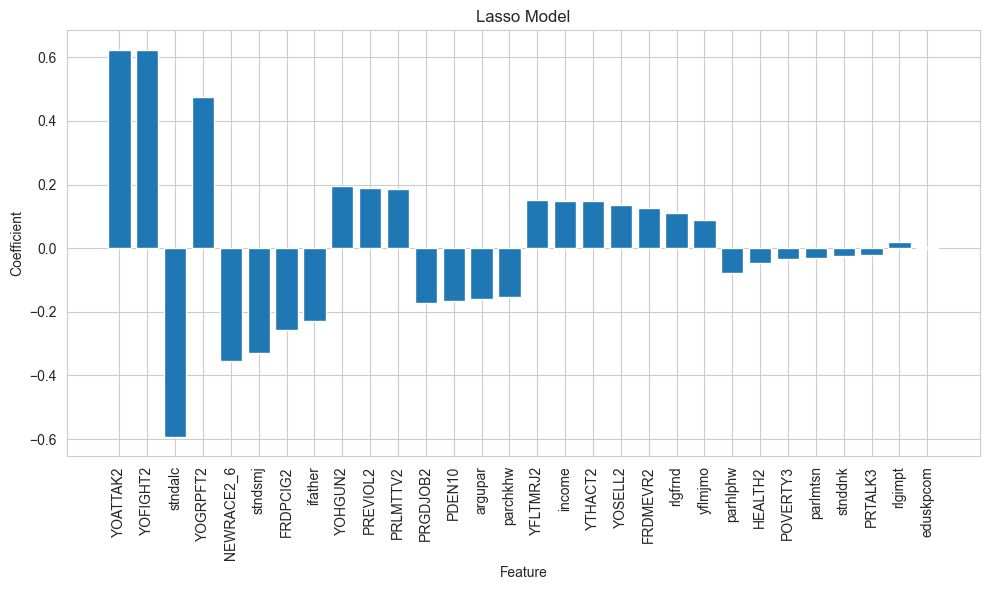

      feature  coefficient  abs_coefficient
0    YOATTAK2     0.623587         0.623587
1    YOFIGHT2     0.623298         0.623298
2     stndalc    -0.593558         0.593558
3    YOGRPFT2     0.475455         0.475455
4  NEWRACE2_6    -0.354749         0.354749


In [17]:
feature_importances = pd.DataFrame({'feature': X.columns, 'coefficient': lasso.coef_})
feature_importances['abs_coefficient'] = abs(feature_importances['coefficient'])
feature_importances = feature_importances.sort_values('abs_coefficient', ascending=False)
feature_importances = feature_importances[feature_importances['coefficient'] != 0]
feature_importances = feature_importances.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['coefficient'])
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title('Lasso Model')
plt.tight_layout()
plt.show()

print(feature_importances.head(5))

## Random Forest Binary Classifier: 'alcflag'

'alcflag' is defined as whether a youth have ever used alcohol. It is a binary categorical variable, so we will apply classification techniques.

### Data Preparation

In [18]:
df_alcflag = df.copy()
X = df_alcflag.drop(substance_dict.keys(), axis=1)
y = df_alcflag['alcflag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=333)

### Single-Parameter Tuning

#### Baseline Model

In [19]:
rf = RandomForestClassifier(max_features='sqrt', n_estimators=100, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[1187   67]
 [ 217  179]]
0.8278787878787879


#### Tune 'n_estimators'

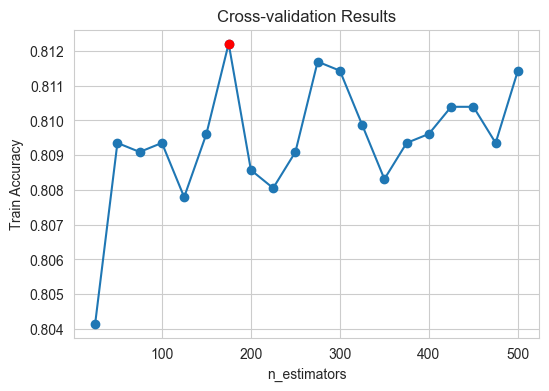

best_n_estimators: 175
best_score: 0.8122077922077923


In [20]:
cv_params = {'n_estimators': np.arange(25, 501, 25)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);
cv_results = cv.cv_results_
best_n_estimators = cv.best_params_['n_estimators']
best_score = cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], 'o-')
plt.plot(best_n_estimators, best_score, 'ro-')
plt.xlabel('n_estimators')
plt.ylabel('Train Accuracy')
plt.title('Cross-validation Results')
plt.show()
print(f"best_n_estimators: {best_n_estimators}")
print(f"best_score: {best_score}")

The optimal 'n_estimators' is 175.

#### Tune 'max_features'

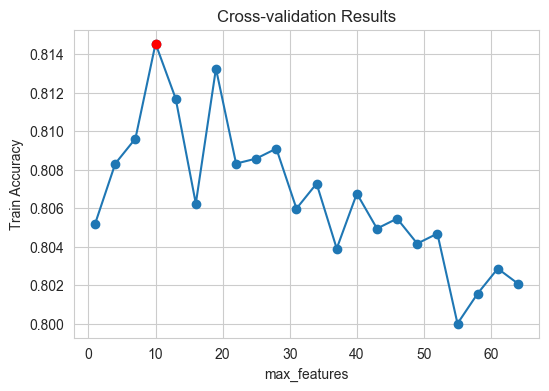

best_max_features: 10
best_score: 0.8145454545454547


In [21]:
rf.set_params(n_estimators=175)
cv_params = {'max_features': np.arange(1, X_train.shape[1] + 1, 3)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);
cv_results = cv.cv_results_
best_max_features = cv.best_params_['max_features']
best_score = cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_max_features'], cv_results['mean_test_score'], 'o-')
plt.plot(best_max_features, best_score, 'ro-')
plt.xlabel('max_features')
plt.ylabel('Train Accuracy')
plt.title('Cross-validation Results')
plt.show()
print(f"best_max_features: {best_max_features}")
print(f"best_score: {best_score}")

The optimal 'max_features' is 10.

#### Evaluation

In [22]:
rf = RandomForestClassifier(n_estimators=175, max_features=10, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[1176   78]
 [ 222  174]]
0.8181818181818182


### Multi-Parameter Tuning

#### Tune both 'n_estimators' and 'max_features'

In [23]:
cv_params = {'n_estimators': np.arange(25, 501, 25), 'max_features': np.arange(1, X_train.shape[1] + 1, 3)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);

/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [24]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
best_n_estimators = cv.best_params_['n_estimators']
best_max_features = cv.best_params_['max_features']
best_score = cv.best_score_

/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/2998427397.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/2998427397.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/2998427397.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')


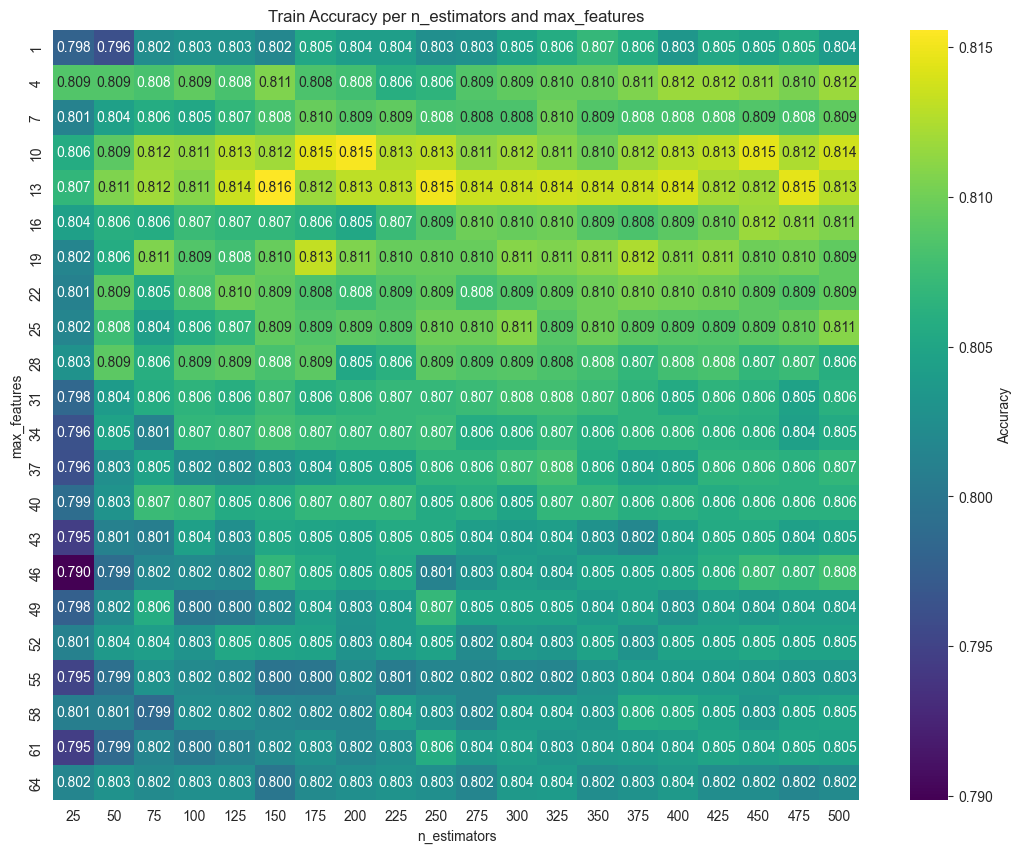

best_n_estimators: 150
best_max_features: 13
best_score: 0.8155844155844155


In [25]:
plt.figure(figsize=(13, 10))
sns.heatmap(cv_table, annot=True, fmt=".3f", cmap='viridis', cbar_kws={'label': 'Accuracy'})
plt.title('Train Accuracy per n_estimators and max_features')
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.show()
print(f"best_n_estimators: {best_n_estimators}")
print(f"best_max_features: {best_max_features}")
print(f"best_score: {best_score}")

#### Evaluation

In [26]:
rf = RandomForestClassifier(max_features=best_max_features, n_estimators=best_n_estimators, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[1175   79]
 [ 219  177]]
0.8193939393939393


The single-parameter tuned model performed better and is less complex compared to the multi-parameter tuned model.

### Model Comparisons

Here we will compare our Random Forest Classification against other models

In [27]:
# gradient boost
boost = GradientBoostingClassifier(random_state=333)
cv_params = {'n_estimators': np.arange(50, 301, 50), 'max_features': np.arange(1, int(np.round(X_train.shape[1] / 2)), 4), 'learning_rate': np.arange(0.001, 0.301, 0.05)}
cv = GridSearchCV(boost, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train)
best_n_estimators = cv.best_params_['n_estimators']
best_max_features = cv.best_params_['max_features']
best_learning_rate = cv.best_params_['learning_rate']
boost = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, learning_rate=best_learning_rate)
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)

print(f"best_n_estimators: {best_n_estimators}")
print(f"best_max_features: {best_max_features}")
print(f"best_learning_rate: {best_learning_rate}")
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

best_n_estimators: 150
best_max_features: 17
best_learning_rate: 0.101
[[1172   82]
 [ 200  196]]
0.8290909090909091


In [28]:
# null model
null_model = DummyClassifier()
null_model.fit(X_train, y_train)
y_pred = null_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[1254    0]
 [ 396    0]]
0.76


### Final Evaluation

Our Random Forest Classification model significantly outperformed the null model and performs slightly better than the Gradient Boosting Classifier. We will use it as our final model. Let's check its most important features.

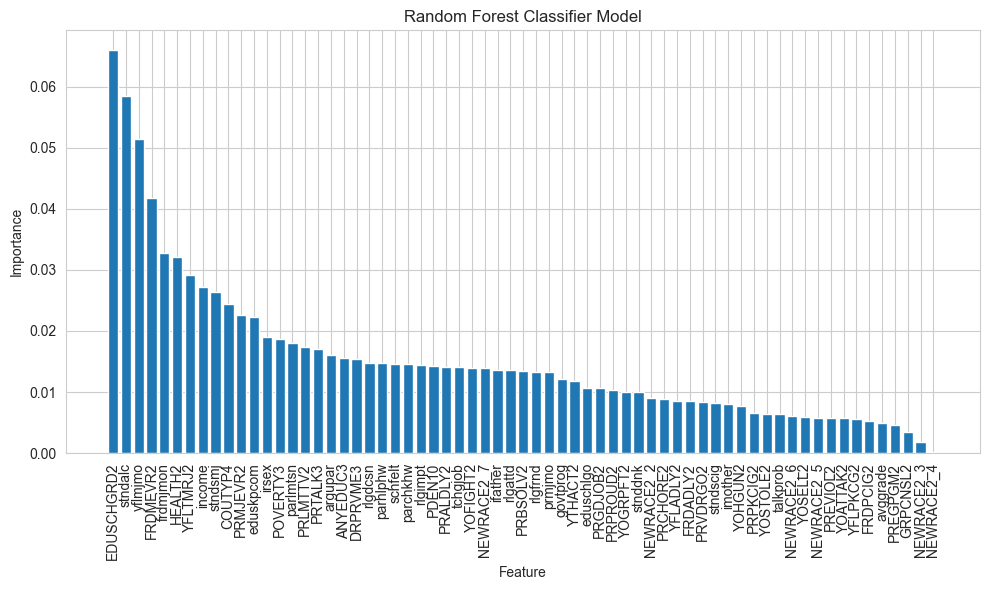

      feature  importance
0  EDUSCHGRD2    0.065901
1     stndalc    0.058377
2     yflmjmo    0.051380
3    FRDMEVR2    0.041730
4    frdmjmon    0.032699


In [29]:
rf = RandomForestClassifier(n_estimators=175, max_features=10, random_state=333)
rf.fit(X_train,y_train)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Random Forest Classifier Model')
plt.tight_layout()
plt.show()

print(feature_importances.head(5))

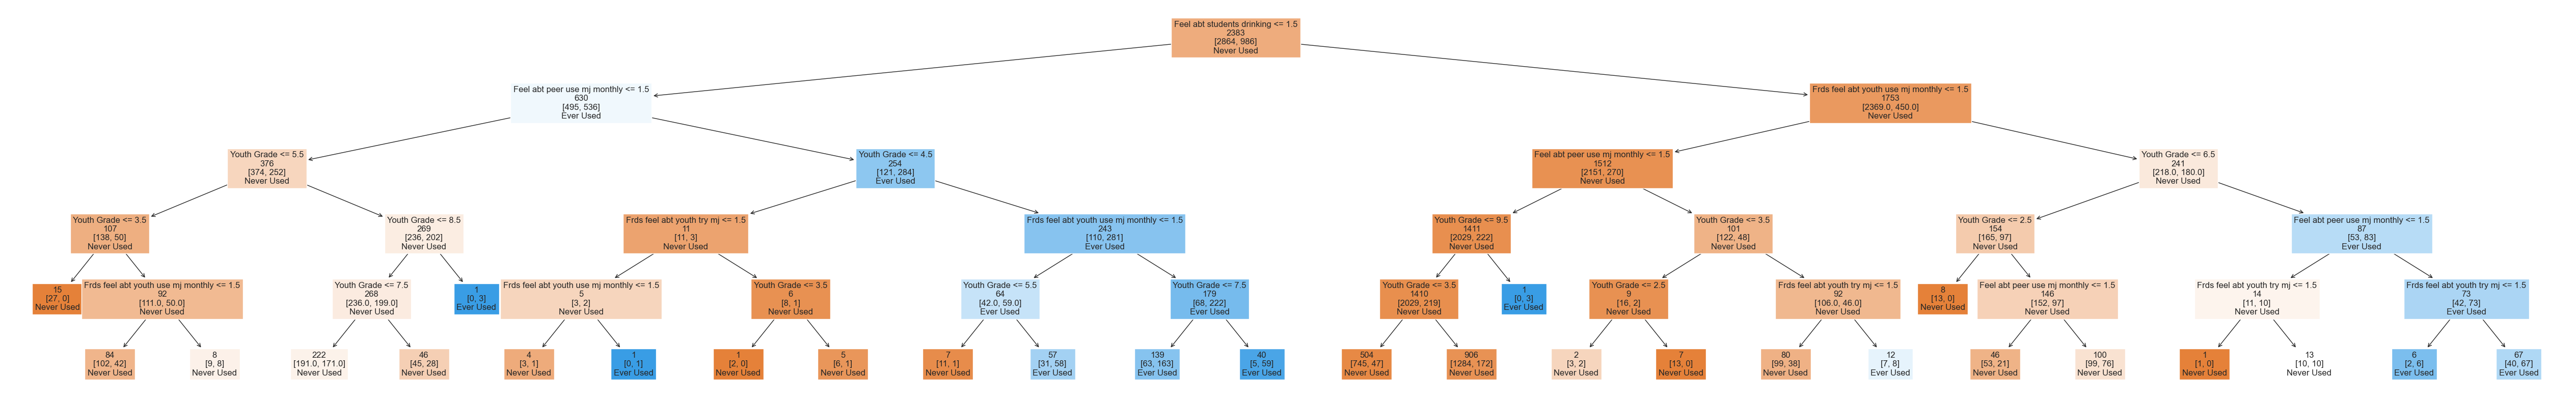

In [30]:
rf = RandomForestClassifier(n_estimators=40, max_features=10, max_depth=5, random_state=333)
col_mapping = {
    "EDUSCHGRD2": "Youth Grade",
    "stndalc": "Feel abt students drinking",
    "yflmjmo": "Feel abt peer use mj monthly",
    "FRDMEVR2": "Frds feel abt youth try mj",
    "frdmjmon": "Frds feel abt youth use mj monthly"

}
rf.fit(X_train[col_mapping.keys()],y_train)
plt.figure(figsize=(65, 10))
plot_tree(rf.estimators_[0], 
          filled=True, 
          feature_names=list(col_mapping.values()),
          class_names=['Never Used', 'Ever Used'],
          impurity=False,
          label='none',
          fontsize=12)
plt.show()

## Random Forest Multi Classifier: 'alcydays'

'alcydays' is defined as the number of days a youth have used alcohol in the past year. It is categorized into 6 levels: 
- 1: 1-11 days
- 2: 12-49 days
- 3: 50-99 days
- 4: 100-299 days
- 5: 300-365 days
- 6: No past year use

We will again apply classification techniques here. 

### Data Preparation

In [31]:
# Remove all rows where 'alcydays' == 6 (means never used, we can combine these findings with alcflag later)
df_alcydays = df.copy()
df_alcydays = df_alcydays[df_alcydays['alcydays'] != 6]
X = df_alcydays.drop(substance_dict.keys(), axis=1)
y = df_alcydays['alcydays']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=333)

### Single-Parameter Tuning

In [32]:
rf = RandomForestClassifier(max_features='sqrt', n_estimators=100, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[194   5   0   0]
 [ 77   5   0   0]
 [ 20   2   0   0]
 [ 23   3   0   0]]
0.6048632218844985


#### Tune 'n_estimators'

/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


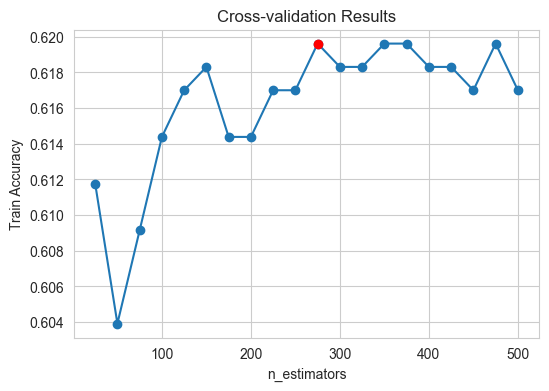

best_n_estimators: 275
best_score: 0.6196078431372549


In [33]:
cv_params = {'n_estimators': np.arange(25, 501, 25)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);
cv_results = cv.cv_results_
best_n_estimators = cv.best_params_['n_estimators']
best_score = cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], 'o-')
plt.plot(best_n_estimators, best_score, 'ro-')
plt.xlabel('n_estimators')
plt.ylabel('Train Accuracy')
plt.title('Cross-validation Results')
plt.show()
print(f"best_n_estimators: {best_n_estimators}")
print(f"best_score: {best_score}")

The best 'n_estimators' is 275, but 150 performs similarly so we will use that.

#### Tune 'max_features'

/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


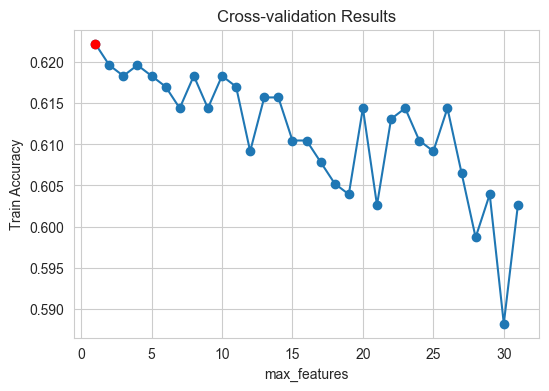

best_max_features: 1
best_score: 0.6222222222222222


In [34]:
rf.set_params(n_estimators=150)
cv_params = {'max_features': np.arange(1, int(X_train.shape[1]/2), 1)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);
cv_results = cv.cv_results_
best_max_features = cv.best_params_['max_features']
best_score = cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results['param_max_features'], cv_results['mean_test_score'], 'o-')
plt.plot(best_max_features, best_score, 'ro-')
plt.xlabel('max_features')
plt.ylabel('Train Accuracy')
plt.title('Cross-validation Results')
plt.show()
print(f"best_max_features: {best_max_features}")
print(f"best_score: {best_score}")

The optimal 'max_features' is 1. There must be a predictor that is so strongly correlated with the response it overshadowed all other predictors.

#### Evaluation

In [35]:
rf = RandomForestClassifier(n_estimators=150, max_features=1, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[199   0   0   0]
 [ 81   1   0   0]
 [ 22   0   0   0]
 [ 25   1   0   0]]
0.60790273556231


### Multi-Parameter Tuning

#### Tune both 'n_estimators' and 'max_features'

In [36]:
cv_params = {'n_estimators': np.arange(25, 301, 25), 'max_features': np.arange(1, int(np.round(X_train.shape[1] / 2)), 1)}
cv = GridSearchCV(rf, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train);

/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [37]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
best_n_estimators = cv.best_params_['n_estimators']
best_max_features = cv.best_params_['max_features']
best_score = cv.best_score_

/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/2998427397.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/2998427397.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')
/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_45711/2998427397.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cv_table = cv_results.pivot('param_max_features', 'param_n_estimators', 'mean_test_score')


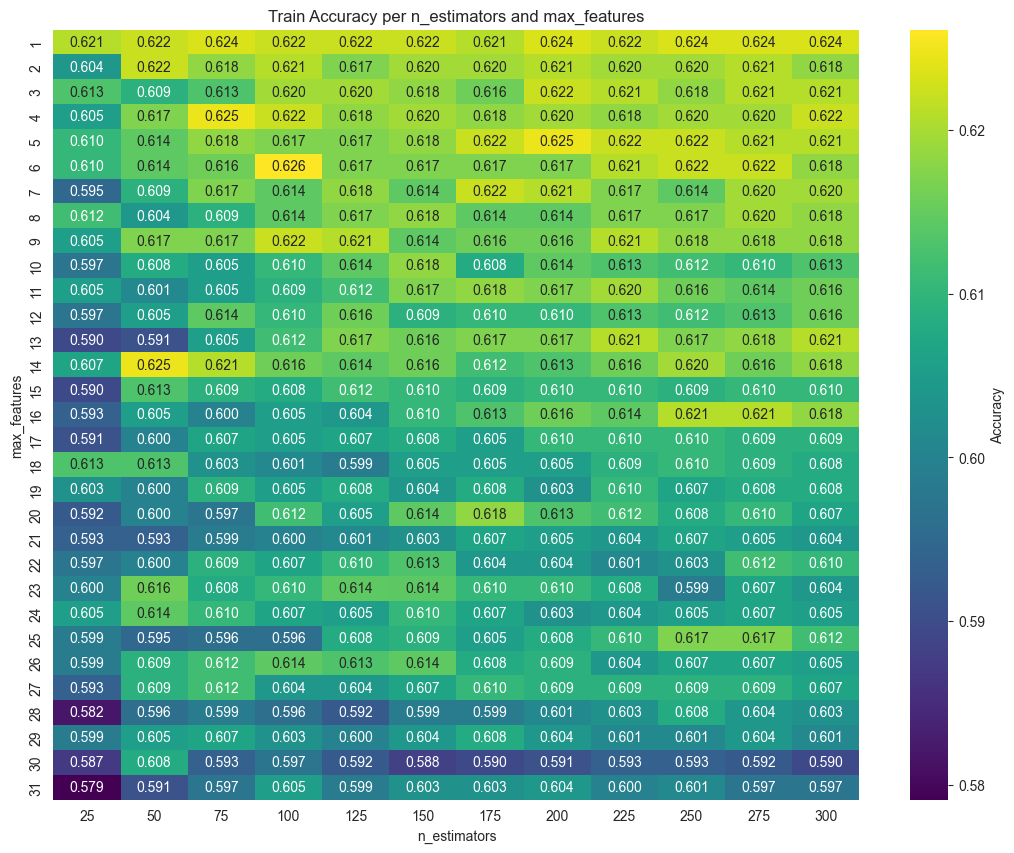

best_n_estimators: 100
best_max_features: 6
best_score: 0.6261437908496732


In [38]:
plt.figure(figsize=(13, 10))
sns.heatmap(cv_table, annot=True, fmt=".3f", cmap='viridis', cbar_kws={'label': 'Accuracy'})
plt.title('Train Accuracy per n_estimators and max_features')
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.show()
print(f"best_n_estimators: {best_n_estimators}")
print(f"best_max_features: {best_max_features}")
print(f"best_score: {best_score}")

#### Evaluation

In [39]:
rf = RandomForestClassifier(max_features=best_max_features, n_estimators=best_n_estimators, random_state=333)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[194   5   0   0]
 [ 77   5   0   0]
 [ 21   1   0   0]
 [ 23   3   0   0]]
0.6048632218844985


Our single-parameter tuned model performed slightly better, but is much much simpler comprising only of 1 feature with a tree size of 150, versus using 6 features with a tree size of 100. 

### Model Comparisons

In [40]:
# gradient boost
boost = GradientBoostingClassifier(random_state=333)
cv_params = {'n_estimators': np.arange(1, 2000, 100), 'max_features': np.arange(1, int(X_train.shape[1]/2), 3), 'learning_rate': np.arange(0.010, 0.101, 0.05)}
cv = GridSearchCV(boost, cv_params, cv=5, scoring='accuracy', n_jobs=-1) # parallelize with all cores
cv.fit(X_train, y_train)
best_n_estimators = cv.best_params_['n_estimators']
best_max_features = cv.best_params_['max_features']
best_learning_rate = cv.best_params_['learning_rate']
boost = GradientBoostingClassifier(n_estimators=best_n_estimators, max_features=best_max_features, learning_rate=best_learning_rate)
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)

print(f"best_n_estimators: {best_n_estimators}")
print(f"best_max_features: {best_max_features}")
print(f"best_learning_rate: {best_learning_rate}")
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


best_n_estimators: 301
best_max_features: 4
best_learning_rate: 0.01
[[199   0   0   0]
 [ 81   1   0   0]
 [ 22   0   0   0]
 [ 22   3   1   0]]
0.60790273556231


In [41]:
# null model
null_model = DummyClassifier()
null_model.fit(X_train, y_train)
y_pred = null_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[199   0   0   0]
 [ 82   0   0   0]
 [ 22   0   0   0]
 [ 26   0   0   0]]
0.6048632218844985


### Final Evaluation

Our Random Forest Classification model slightly outperformed the null model. Now let's check its most important features.

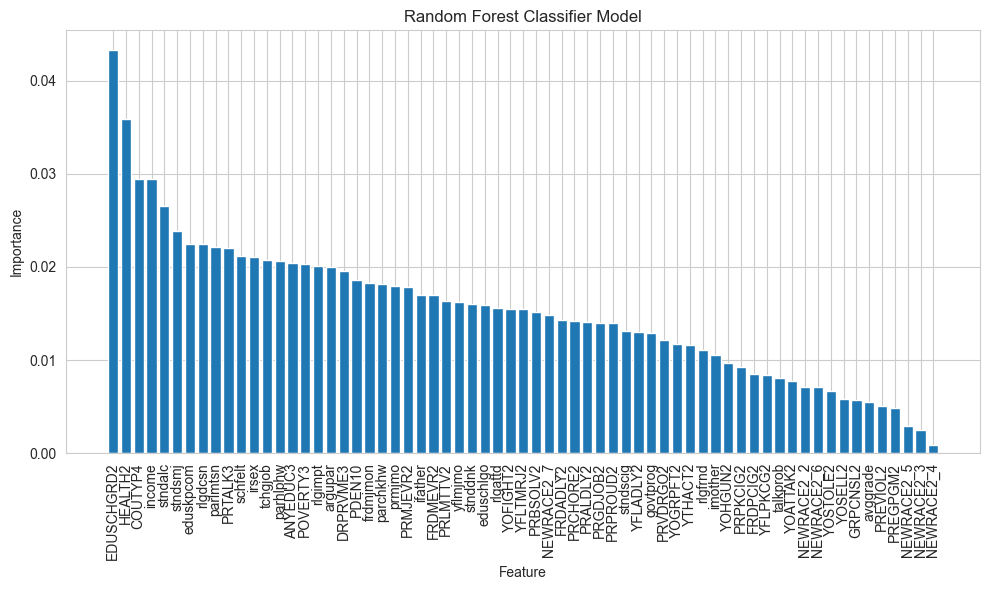

      feature  importance
0  EDUSCHGRD2    0.043249
1     HEALTH2    0.035853
2     COUTYP4    0.029476
3      income    0.029443
4     stndalc    0.026536


In [42]:
rf = RandomForestClassifier(n_estimators=150, max_features=1, random_state=333)
rf.fit(X_train,y_train)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Random Forest Classifier Model')
plt.tight_layout()
plt.show()

print(feature_importances.head(5))

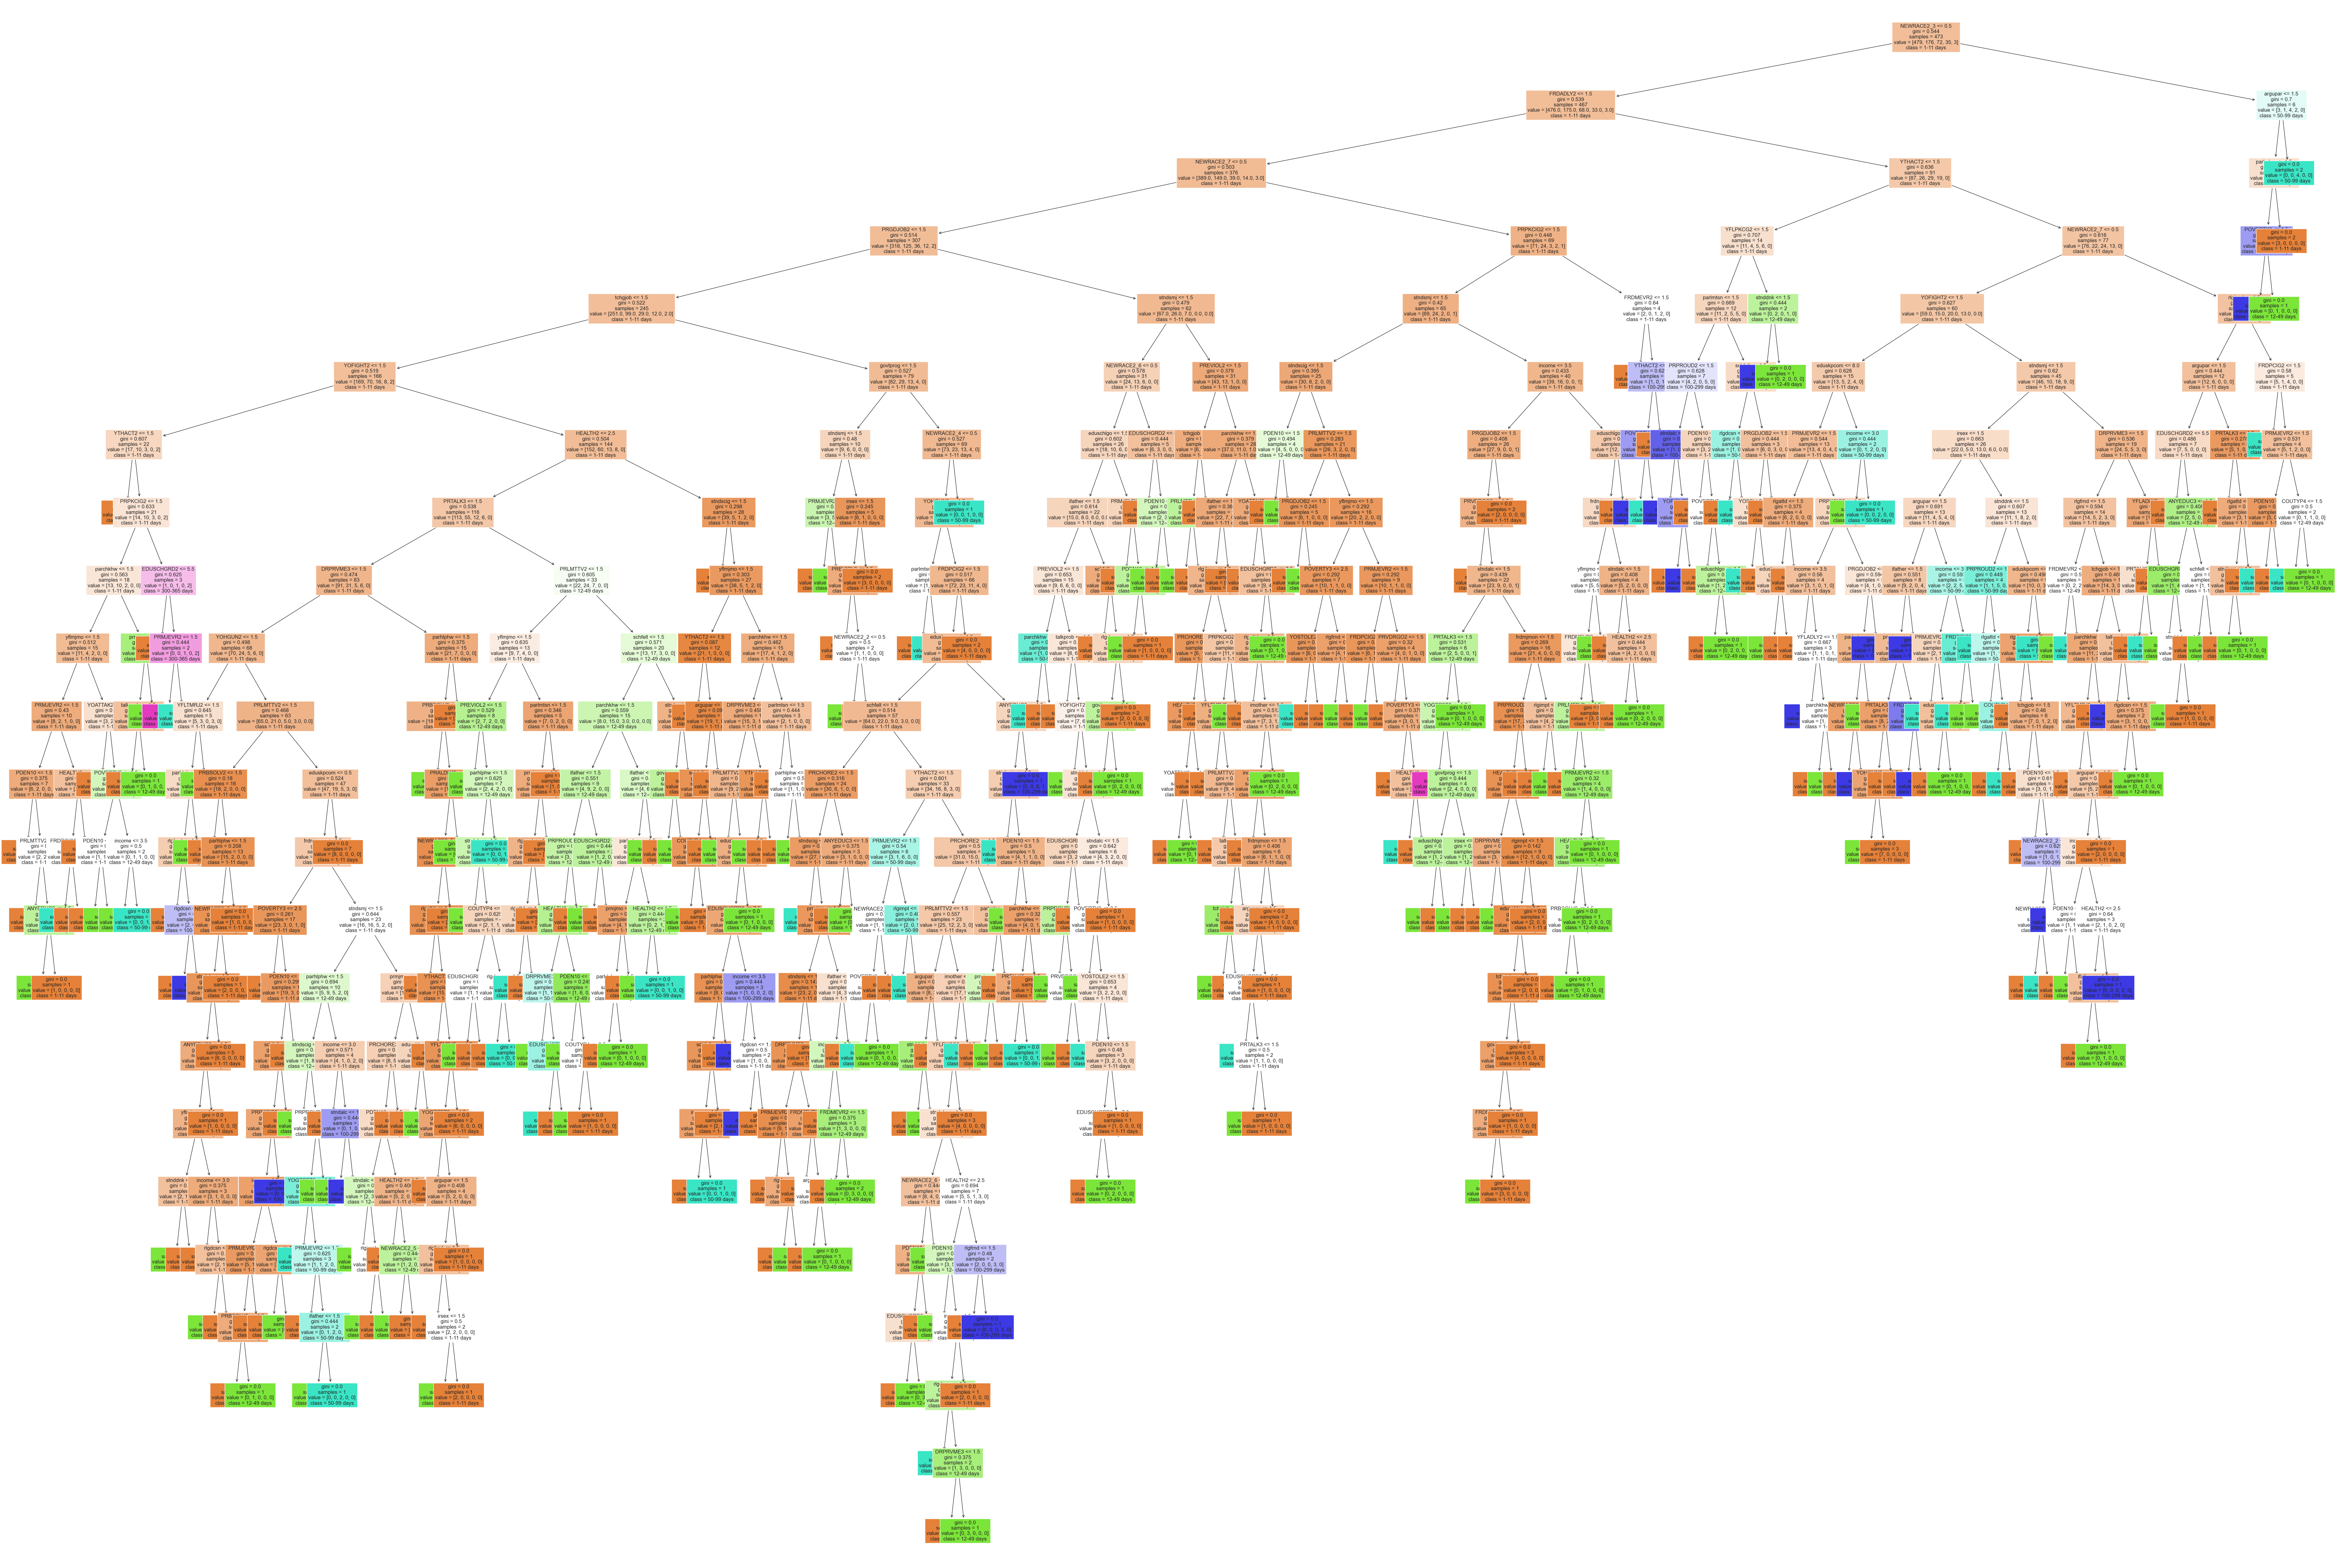

In [43]:
plt.figure(figsize=(95, 65))
plot_tree(rf.estimators_[0], 
          filled=True, 
          feature_names=X_train.columns,
          class_names=['1-11 days', '12-49 days', '50-99 days', '100-299 days', '300-365 days'],
          label='all',
          fontsize=12)
plt.show()

## Additional Plots

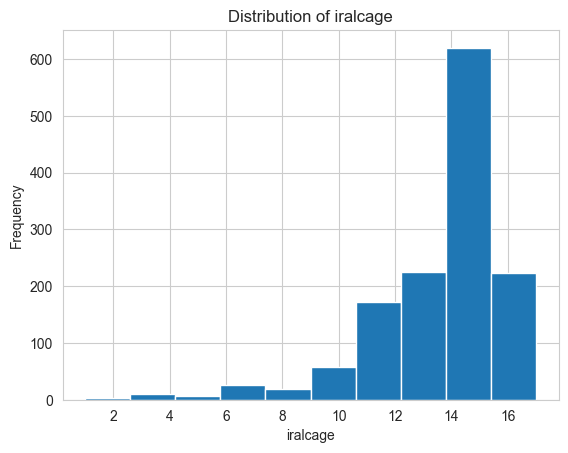

In [44]:
# Use in intro
plt.hist(df_iralcage['iralcage'])
plt.xlabel('iralcage')
plt.ylabel('Frequency')
plt.title('Distribution of iralcage')
plt.show()